## Preparing Data 

#### download frm : [Name Data](https://download.pytorch.org/tutorial/data.zip)

###### Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

######  We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

data_dir = "./data/names/*.txt"
def findFiles(filePath):
    return glob.glob(filePath)

print("Files \n", findFiles(data_dir), "\n")

import unicodedata, string

all_letters = string.ascii_letters+ " .,;'"
n_letters = len(all_letters)

# Unicode to ascii 
def unicode2ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn'
                  and c in all_letters)

print(unicode2ascii('Ślusàrski'))

# Build category dict, list of names per language 
category_lines = {}
all_categories = []

#Read file and line split 
def readLine(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode2ascii(line) for line in lines]

for fileName in findFiles(data_dir):
    category = fileName.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLine(fileName)
    category_lines[category] = lines

n_categories = len(all_categories)

Files 
 ['./data/names/Arabic.txt', './data/names/Chinese.txt', './data/names/Czech.txt', './data/names/Dutch.txt', './data/names/English.txt', './data/names/French.txt', './data/names/German.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/Italian.txt', './data/names/Japanese.txt', './data/names/Korean.txt', './data/names/Polish.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/Spanish.txt', './data/names/Vietnamese.txt'] 

Slusarski


## Turning Names Into Tensors 
#### Letter -> One hot Vector 
#### Word -> 2d matrix of all One hot Vectors 
Extra dim in pytorch, coz it assumes everything in minibatch. Thus 1 minibatch here



In [3]:
import torch

# Find letter Index from all_letters
def letter2Index(letter):
    return all_letters.find(letter)

# Create tensor of letter (1Xn_letters)- just to understand 
def letter2Tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter2Index(letter)] = 1
    return tensor

# Create tensor of line ( line_length X 1 X n_letters)  - one hot vector stack of line
def line2Tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter2Index(letter)] = 1
    return tensor


print(letter2Tensor('J'))

print(line2Tensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


## Creating the Network 
##### This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.


![picture alt](https://i.imgur.com/Z2xbySO.png)

In [4]:
import torch.nn as nn 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
               
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input,hidden), 1)
        hidden = self.i2h(combined)
        # Output : probability of each language 
        output = self.softmax(self.i20(combined))
        return output, hidden 
    # Initialise hidden with zeros, as forward step needs input and previous hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
        

In [5]:
# Using rnn forward above : 
ingput  = letter2Tensor('S')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(ingput, hidden)

print(output)
# To optimize we use line tensor, so as not to create a tensor for each letter :
# To do : further optimize by batches of tensor 

ingput = line2Tensor('Saleem')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(ingput[0], hidden)

# output is 1 X N categories where every value is likelihood of each category
print(output)

tensor([[-2.9927, -2.8078, -2.9915, -2.8750, -2.8890, -2.8665, -2.8726,
         -2.9267, -2.8263, -2.8824, -2.8876, -2.8107, -2.9356, -2.8999,
         -2.9129, -2.9169, -2.9084, -2.8473]])
tensor([[-2.9927, -2.8078, -2.9915, -2.8750, -2.8890, -2.8665, -2.8726,
         -2.9267, -2.8263, -2.8824, -2.8876, -2.8107, -2.9356, -2.8999,
         -2.9129, -2.9169, -2.9084, -2.8473]])


## Training 
#### Preparing for Training : 

In [6]:
# use tensor.topk(k) to get highest value, for interpreting the output 
# return top valu and index
def catFromOutput(output):
    top_n, top_i  = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

catFromOutput(output)

('Chinese', 1)

In [7]:
# Quickly get training sample : Name, language 
import random 
def randomChoice(l) :
    return l[random.randint(0, len(l)-1)]

def randomTraininSample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line2Tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTraininSample()
    print('category =', category, '/ line =', line)
    
    

category = French / line = Salvage
category = Russian / line = Baer
category = Vietnamese / line = An
category = Vietnamese / line = Lam
category = Vietnamese / line = Chung
category = Polish / line = Pasternak
category = Korean / line = Choi
category = Irish / line = Donoghue
category = Czech / line = Ocaskova
category = Italian / line = Stablum


In [8]:
category = randomChoice(all_categories)
print(category)
print(all_categories.index(category))
line = randomChoice(category_lines[category])
print(line)

Scottish
15
Watson


#### Actually Training The Network
##### define loss function - using negative log likelihood loss 

> Each loop of training will:

> * Create input and target tensors
> * Create a zeroed initial hidden state
> * Read each letter in and
> * Keep hidden state for next letter
> * Compare final output to target
> * Back-propagate
> * Return the output and loss

In [9]:
rnn.zero_grad()
print(loss)

NameError: name 'loss' is not defined

In [16]:
criterion = nn.NLLLoss()

lr = 0.001
def train(cat_tensor, line_tensor):
    # print("catt",cat_tensor,"lint", line_tensor)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    #print('....................', output.size(), cat_tensor.size())
    loss = criterion(output, cat_tensor)
    loss.backward()
#     print("loss", loss.item())
    
    # Add parameter gradient *lr to update weight 
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), 0.025)
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
    
    return output, loss.item()

In [11]:
# Run train with train data and print output also average loss 
import time 
import math 

n_iters = 100000
print_every =  5000
plot_every = 1000 

# Keep Track of losses for plotting 

current_loss = 0 ; 
all_losses = [];

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters +1) :
    category, line, category_tensor, line_tensor = randomTraininSample()    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss 
    
    #Print iter, name, loss and guess 
    if iter % print_every == 0:
        guess, guess_i = catFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0




/home/sal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


5000 5% (0m 5s) 2.8512 Hamchiev / Chinese ✗ (Russian)
10000 10% (0m 11s) 2.8482 Zha / Spanish ✗ (Chinese)
15000 15% (0m 17s) 2.8684 Zambrano / Portuguese ✗ (Spanish)
20000 20% (0m 24s) 2.7660 Liu / Russian ✗ (Chinese)
25000 25% (0m 30s) 2.8663 Vinh / German ✗ (Vietnamese)
30000 30% (0m 38s) 2.7612 Hausler / German ✓
35000 35% (0m 43s) 2.9678 Doan / English ✗ (Vietnamese)
40000 40% (0m 50s) 2.8056 Ceallach / Irish ✓
45000 45% (0m 56s) 2.8526 Chemlik / Greek ✗ (Czech)
50000 50% (1m 1s) 2.7947 Eoin / Scottish ✗ (Irish)
55000 55% (1m 8s) 2.6766 Auer / German ✓
60000 60% (1m 15s) 2.9046 Soho / Portuguese ✗ (Japanese)
65000 65% (1m 22s) 2.7169 Chang / Chinese ✓
70000 70% (1m 31s) 2.8354 Snider / German ✗ (Dutch)
75000 75% (1m 37s) 2.8782 Baz / Irish ✗ (Arabic)
80000 80% (1m 43s) 2.6640 Cathan / Irish ✓
85000 85% (1m 49s) 2.6294 Ping / Chinese ✓
90000 90% (1m 55s) 2.9227 Koury / Russian ✗ (Arabic)
95000 95% (2m 1s) 2.8835 Tuma / Japanese ✗ (Arabic)
100000 100% (2m 7s) 2.7823 Moon / Scottish ✗

## Plotting Results 


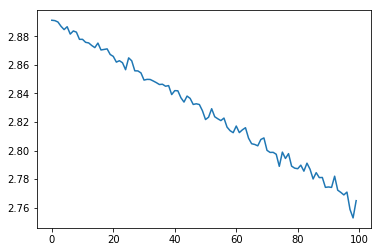

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## Evaluating the Result 
#### Creating the confusion matrix

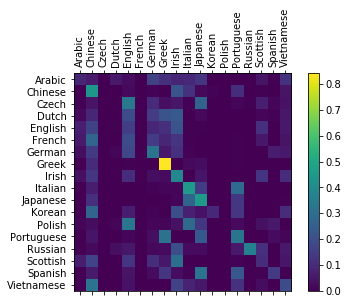

In [15]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_iters
def evaluate(line_tensor): 
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, loss = rnn(line_tensor[i], hidden)
    return output

# Go thoriugh training data for creating the confusion matrix 
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTraininSample()
    output =  evaluate(line_tensor)
    guess, guess_i = catFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
    

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

## Running on User Input

In [17]:
def predict (input_line, n_pred =3):
    print('\n>%s'%input_line )
    with torch.no_grad():
        output = evaluate(line2Tensor(input_line))
           # Get top N categories
        topv, topi = output.topk(n_pred, 1, True)
        predictions = []

        for i in range(n_pred):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')   
            
            


>Dovesky
(-2.78) Scottish
(-2.81) Russian
(-2.83) Chinese

>Jackson
(-2.70) Irish
(-2.72) Scottish
(-2.73) Chinese

>Satoshi
(-2.63) Italian
(-2.79) Polish
(-2.80) Japanese


In [18]:
predict('Aayesha')   


>Aayesha
(-2.69) Japanese
(-2.70) Spanish
(-2.81) Czech
